# Prerequisites

Before running this notebook, you will need to do the following

### Install Oracle AutoML Conda environment


In [1]:
!odsc conda install -s automlx_p38_cpu_v1


Environment slug: automlx_p38_cpu_v1
INFO:ODSC:Downloading conda pack automlx_p38_cpu_v1...
INFO:ODSC:Writing to /home/datascience/.automlx_p38_cpu_v1.tar.gz
INFO:ODSC:download complete
INFO:ODSC:Extracting conda environment `/home/datascience/.automlx_p38_cpu_v1.tar.gz`
INFO:ODSC:Running conda-unpack script.
INFO:ODSC:Downloading Notebooks for the pack: Oracle AutoML and Model Explanation for Python 3.8
INFO:ODSC:Conda environment has been successfully installed.
Removing: /home/datascience/.automlx_p38_cpu_v1.tar.gz
The environment setup is complete. To activate, run `conda activate /home/datascience/conda/automlx_p38_cpu_v1` in your terminal. It may take a few seconds for the kernel to appear in the JupyterLab launcher. To change the description of the environment, update /home/datascience/conda/automlx_p38_cpu_v1/*_manifest.yaml.


Wait for the message "The environment setup is complete". Once the installation is complete, go to the Kernel menu above and select Change Kernel. Choose the automlx_p38_cpu_v1 kernel as shown below

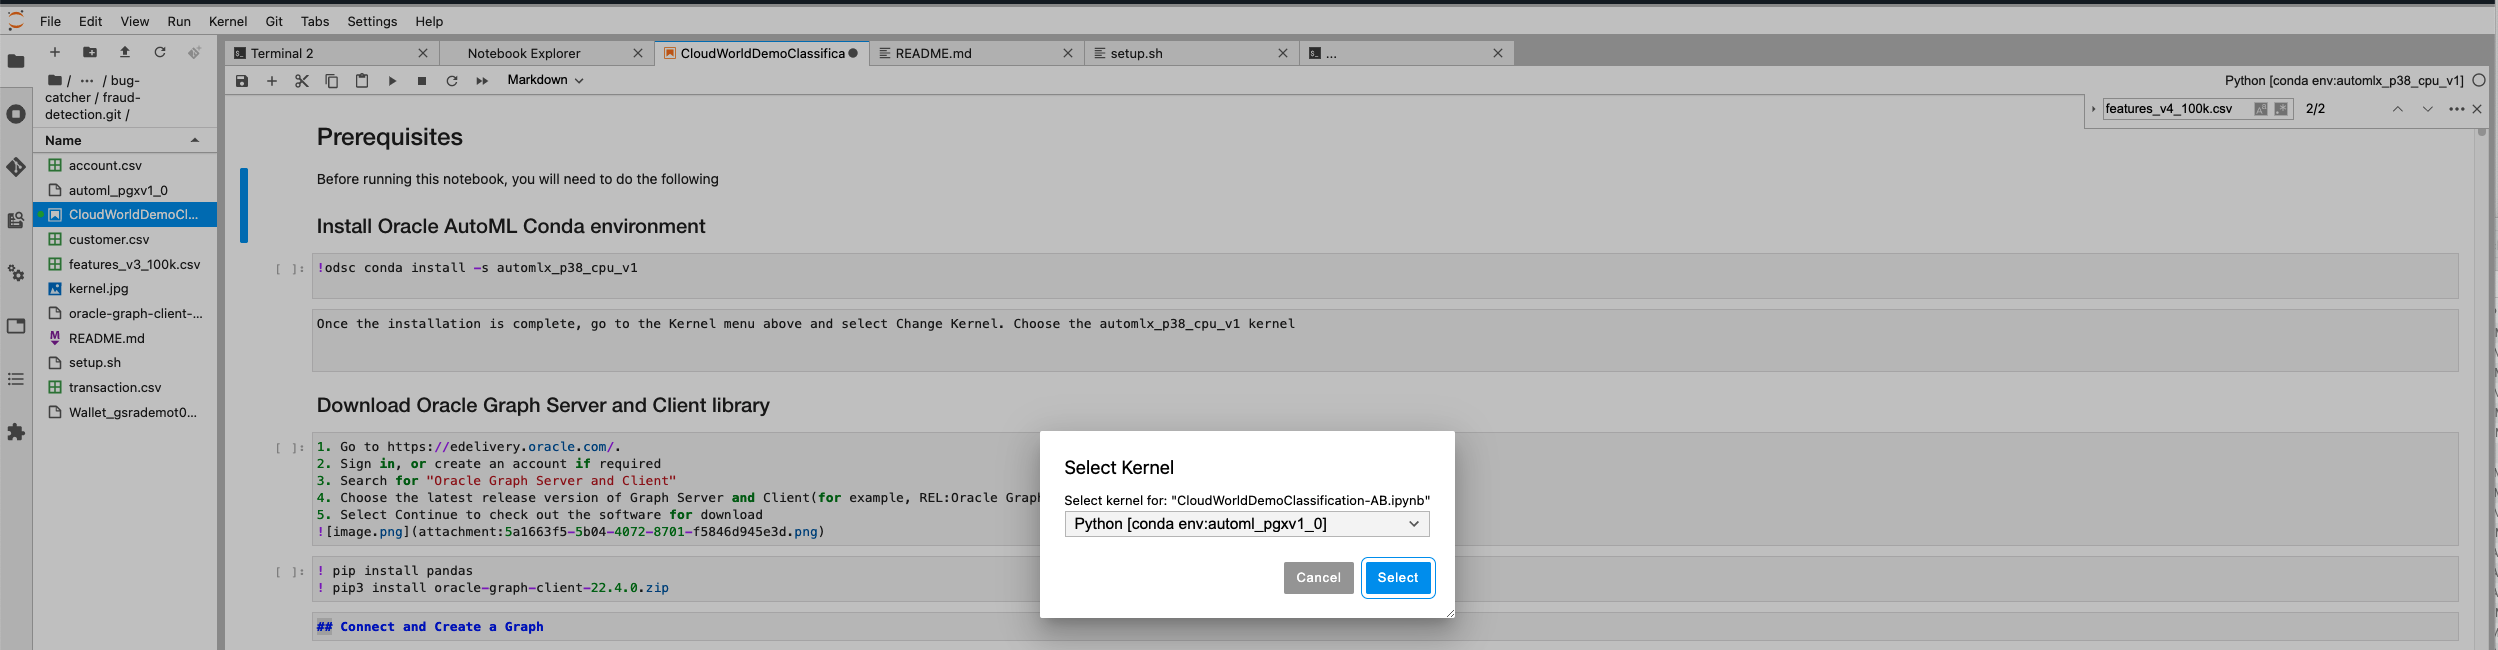


### Install Pandas

In [ ]:
!pip install pandas

### Download and install Oracle Graph Server and Client library

1. Go to https://edelivery.oracle.com/.
2. Sign in, or create an account if required
3. Search for "Oracle Graph Server and Client"
4. Choose the latest release version of Graph Server and Client for Linux (for example, REL:Oracle Graph Server and Client 22.4.0.0)
5. Select Continue to check out the software for download
6. Upload the zip file and install Oracle Graph Client

In [1]:
!unzip -o oracle-graph-client-22.4.0.zip
!cd oracle-graph-client-22.4.0 && pip3 install .

Processing ./oracle-graph-client-22.4.0.zip
  Preparing metadata (setup.py) ... done
  Created wheel for pypgx: filename=pypgx-22.4.1-py3-none-any.whl size=89974160 sha256=4480d4af5f2bd7a8cd972060e65505c21feb2efdaaa883105c34aa3c7c854e69
  Stored in directory: /home/datascience/.cache/pip/wheels/e8/54/6d/bd39c78bd5bacd73a4db80f0bd9e227c9f1eb158ed820eeca1
Successfully built pypgx


### Load data

#### Unzip transactions dataset

In [ ]:
!gunzip transaction.csv.gz

### Download the database wallet files from vault
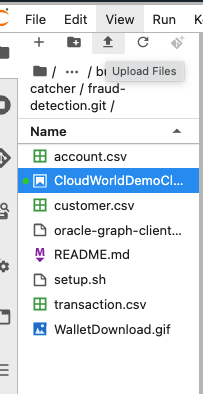

#### Create vault and secret client

In [ ]:
import oci

signer = oci.auth.signers.get_resource_principals_signer()
vault_client = oci.vault.VaultsClient(config={}, signer=signer)
secret_client = oci.secrets.SecretsClient(config={}, signer=signer)

#### Use vault client to list secrets

In [ ]:
import os

compartment_id = os.environ.get('PROJECT_COMPARTMENT_OCID')
vault_id = os.environ.get('ADB_VAULT_OCID')
secret_list = vault_client.list_secrets(compartment_id=compartment_id, vault_id=vault_id).data
print(len(secret_list))

#### Function that use secret client to get content based on secret ocid

In [ ]:
def get_secret_content(secret_ocid):
    get_secret_response = secret_client.get_secret_bundle(secret_id=secret_ocid)
    utf_8_secert = get_secret_response.data.secret_bundle_content.content
    base64_content = utf_8_secert.encode('utf-8')
    return base64.b64decode(base64_content)

#### Traverse secret_list and if the secret is in wallet_file_names, download the file and compress it into wallet.zip file

In [ ]:
import zipfile
import base64

wallet_file_names = ["README", "cwallet.sso", "ewallet.p12", "ewallet.pem", "keystore.jks", "ojdbc.properties", "tnsnames.ora", "truststore.jks", "sqlnet.ora"]
zf = zipfile.ZipFile("wallet.zip", mode="w")

for secret in secret_list:
    if secret.secret_name in wallet_file_names:
        file_content = get_secret_content(secret.id)
        print ("File " + secret.secret_name + " successfully fetched!")
        file = open(secret.secret_name, 'wb')
        file.write(file_content)
        file.close()
        zf.write(secret.secret_name, secret.secret_name, compress_type=zipfile.ZIP_DEFLATED)
        os.remove(secret.secret_name)
zf.close()
print ("wallet.zip successfully created!")

### Connect to ADB instance

In [ ]:
import os
import os.path
from oci.config import from_file
import oci

# Select the configuration file to connect to Oracle Cloud Infrastructure resources
import ads
from ads.vault.vault import Vault

ads.set_auth(auth='resource_principal')
ads.set_debug_mode(mode=True)


connection_parameters = {
    "user_name": "admin",
    "password": os.environ.get('ADB_ADMIN_PASSWORD'),
    "service_name": os.environ.get('DATABASE_NAME') + "_high",
    "wallet_location": "wallet.zip"
}
import pandas as pd

customers = pd.read_csv('customer.csv')
account = pd.read_csv('account.csv')
transaction = pd.read_csv('transaction.csv')
print(customers.head())
print(account.head())
print(transaction.head())
customers.ads.to_sql('customer', connection_parameters=connection_parameters, if_exists="replace")
account.ads.to_sql('account', connection_parameters=connection_parameters, if_exists="replace")
transaction.ads.to_sql('transaction', connection_parameters=connection_parameters, if_exists="replace")


## Connect and Create a Graph

In [ ]:
import opg4py
import pypgx
from opg4py.adb import AdbClient

# Disable default DEBUG logging
pypgx.setloglevel("ROOT","INFO")


# Step 1: connect to the ADB Graph Studio environment

# Set up database name, tenancy, username and password
database = os.environ.get('DATABASE_NAME')
tenant   = os.environ.get('TENANCY_OCID')
username = "graphuser"
password =  os.environ.get('ADB_GRAPHUSER_PASSWORD')
endpoint = os.environ.get('GRAPH_STUDIO_URL')

# Setup client configuration
config = {
  'tenant':   tenant,
  'database': database,
  'username': username,
  'password': password,
  'endpoint': endpoint
}

# Connect with your studio environment
client = AdbClient(config)
client.__enter__()

# Step 2: start the PGX environment in Graph Studio

# Check environment status:
client.is_attached()
client.get_environment_status().name()

# Start the PGX environment.
# IMPORTANT:
# 1. The environment may already exist: only start it if it does not
# 2. The operation is ASYNCHRONOUS: you need to wait for it to complete
#     The job polls the server for completion, every 1000ms
#     Use the get() or join() method on the job to make it wait until completion
# 3. The operation takes a while to complete (20 to 30 seconds)
memory_gb=32
if not client.is_attached():
  print ("Starting the environment ...")
  client.start_environment(memory_gb).get()

print ("Environment is ready")

# Step 3: Create Instance and session

# Connect to graph server
instance = client.get_pgx_instance()

# Create a session
session = instance.create_session("python-adb")

print(session)

In [ ]:
statement = """
CREATE PROPERTY GRAPH graph2
  VERTEX TABLES (
    customer
      KEY (cst_id)
      LABEL customer
      PROPERTIES (cst_id, first_name, last_name)
  , account
      KEY (acc_id)
      LABEL account
      PROPERTIES (acc_id, cst_id)
  )
  EDGE TABLES (
    transaction
      KEY (txn_id)
      SOURCE KEY(acc_id_src) REFERENCES account
      DESTINATION KEY(acc_id_dst) REFERENCES account
      LABEL transferred_to
  , account
      KEY (acc_id)
      SOURCE KEY(cst_id) REFERENCES customer
      DESTINATION KEY(acc_id) REFERENCES account
      LABEL owns
  )
"""
session.prepare_pgql(statement).execute()

In [ ]:
graph = session.get_graph("GRAPH2")
graph

In [ ]:
import time
pypgx.setloglevel("ROOT", "INFO")
time_sta = time.time()
statement = """
SELECT *
FROM MATCH (a1:account)-/:transferred_to*/->(a2:account) ON graph2
WHERE a1.acc_id = 10
"""
session.prepare_pgql(statement).execute()
time_end = time.time()
print(time_end-time_sta)

## Remove customer vertices

In [ ]:
graph.destroy_vertex_property_if_exists("cst_first_name")
graph.destroy_vertex_property_if_exists("cst_last_name")
graph.create_vertex_property("string", "cst_first_name")
graph.create_vertex_property("string", "cst_last_name")

In [ ]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a SET (a.cst_first_name = c.first_name)
  FROM MATCH (a:account)<-[:owns]-(c:customer)
""")
graph

In [ ]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a SET (a.cst_last_name = c.last_name)
  FROM MATCH (a:account)<-[:owns]-(c:customer)
""")
graph

In [ ]:
graph = graph.clone(name="GRAPH3") 
graph.execute_pgql("""
DELETE c FROM MATCH (c:customer)
""")
graph

In [ ]:
session.query_pgql("""
  SELECT
    count(a)
  FROM MATCH (a) ON graph3
  LIMIT 50
""").print()

In [ ]:
session.query_pgql("""
  SELECT
    count(e)
  FROM MATCH ()-[e]->() ON graph3
  LIMIT 50
""").print()

In [ ]:
session.query_pgql("""
  SELECT
    count(DISTINCT ID(v1)||ID(v2))
  FROM MATCH (v1)->(v2) ON graph3
  LIMIT 50
""").print()

## Centrality

In [ ]:
analyst = session.create_analyst()

graph.destroy_vertex_property_if_exists("degree")
analyst.degree_centrality(graph)

In [ ]:
graph.destroy_vertex_property_if_exists("in_degree")
analyst.in_degree_centrality(graph)

In [ ]:
graph.destroy_vertex_property_if_exists("out_degree")
analyst.out_degree_centrality(graph)

In [ ]:
graph.destroy_vertex_property_if_exists("pagerank")
analyst.pagerank(graph)

In [ ]:
graph.destroy_vertex_property_if_exists("approx_betweenness")
analyst.approximate_vertex_betweenness_centrality(graph, 100)

In [ ]:
graph.destroy_vertex_property_if_exists("eigenvector")
analyst.eigenvector_centrality(graph)

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY approx_betweenness DESC
  LIMIT 10
""").print()

## Community Detection

In [ ]:
analyst.communities_label_propagation(graph)

In [ ]:
analyst.communities_conductance_minimization(graph)
#analyst.communities_conductance_minimization(graph, max_iter=100)

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.label_propagation
  , a.conductance_minimization
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY acc_id
  LIMIT 5
""").print()

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.label_propagation
  , a.conductance_minimization
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
    AND a.conductance_minimization = 1
""").print()

## Add fraud flags

In [ ]:
graph = graph.clone(name="GRAPH4")
graph

In [ ]:
graph = session.get_graph(name="GRAPH4")
graph

In [ ]:
graph.destroy_vertex_property_if_exists("is_fraud")
graph.create_vertex_property("boolean", "is_fraud")

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.approx_betweenness
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.approx_betweenness DESC
  LIMIT 10
  OFFSET 3000
""").print()

In [ ]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.approx_betweenness > 1259.9120208559327
  AND x.acc_id % 3 = 0
""")
graph

In [ ]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

In [ ]:
graph.query_pgql("""
  SELECT a.conductance_minimization, COUNT(*)
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  GROUP BY a.conductance_minimization
  ORDER BY COUNT(*) DESC
  LIMIT 20
""").print()

In [ ]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.conductance_minimization IN (98, 297, 537, 82, 1103, 344, 1235)
  AND x.acc_id % 3 = 0
""")
graph

In [ ]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

## Closeness to Known Fraud Accounts

In [ ]:
#rs = graph.query_pgql("SELECT ID(a) FROM MATCH (a) WHERE a.is_fraud = true")
#vertices = graph.create_vertex_set()
#for i in rs:
#    vertices.add(graph.get_vertex(i))
#graph.destroy_vertex_property_if_exists("fraud_closeness")
#analyst.personalized_pagerank(graph, vertex, rank="fraud_closeness")

In [ ]:
import pypgx
vertices = graph.get_vertices(pypgx.VertexFilter("vertex.is_fraud=TRUE"))
graph.destroy_vertex_property_if_exists("fraud_closeness")
analyst.personalized_pagerank(graph, vertices, rank="fraud_closeness")

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_closeness
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
  LIMIT 10
""").print()

## Calculate fraud_neighbors

In [ ]:
graph.destroy_vertex_property_if_exists("in_fraud_neighbors")
graph.destroy_vertex_property_if_exists("out_fraud_neighbors")
graph.destroy_vertex_property_if_exists("fraud_neighbors")
graph.create_vertex_property("integer", "in_fraud_neighbors")
graph.create_vertex_property("integer", "out_fraud_neighbors")
graph.create_vertex_property("integer", "fraud_neighbors")

In [ ]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(t1), a1.fraud_closeness
  FROM MATCH (a1)<-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

In [ ]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(t1), a1.fraud_closeness
  FROM MATCH (a1)-[t1:transferred_to]->(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

In [ ]:
graph.query_pgql("""
  SELECT ID(a1), COUNT(DISTINCT a2), COUNT(t1) AS cnt, a1.fraud_closeness
  FROM MATCH (a1)-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
  LIMIT 10
""").print()

In [ ]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.in_fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)<-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

In [ ]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.out_fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)-[t1:transferred_to]->(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

In [ ]:
graph = graph.clone_and_execute_pgql("""
  UPDATE a1 SET (a1.fraud_neighbors = COUNT(t1))
  FROM MATCH (a1)-[t1:transferred_to]-(a2)
  WHERE a2.is_fraud = true
  GROUP BY a1
""")
graph

## Add fraud flags for high fraud_neighbours accounts

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_neighbors
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_neighbors DESC
  LIMIT 10
  OFFSET 3000
""").print()

In [ ]:
graph = graph.clone_and_execute_pgql("""
UPDATE x SET (x.is_fraud = true) FROM MATCH (x:account)
WHERE x.fraud_neighbors > 6
  AND x.acc_id % 3 = 0
""")
graph

In [ ]:
graph.query_pgql("""
  SELECT COUNT(*)
  FROM MATCH (a)
  WHERE a.is_fraud = true
""").print()

## Calculate fraud_closeness_2

In [ ]:
import pypgx
vertices = graph.get_vertices(pypgx.VertexFilter("vertex.is_fraud=TRUE"))
graph.destroy_vertex_property_if_exists("fraud_closeness_2")
analyst.personalized_pagerank(graph, vertices, rank="fraud_closeness_2")

In [ ]:
graph.query_pgql("""
  SELECT
    a.acc_id
  , a.fraud_closeness
  , a.fraud_closeness_2
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
  LIMIT 10
""").print()

In [ ]:
graph.query_pgql("""
  SELECT
    a.is_fraud
  , AVG(a.fraud_closeness)
  , AVG(a.fraud_closeness_2)
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  GROUP BY is_fraud
""").print()

## Store Features to Data Frame

In [ ]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.acc_id
""")

In [ ]:
df = rs.to_pandas()
df

In [ ]:
df.to_csv('./features_v3_100k.csv')

In [ ]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE LABEL(a) = 'ACCOUNT'
  ORDER BY a.fraud_closeness DESC
""")

In [ ]:
rs_df = rs.to_pandas()
rs_df

## ML

In [ ]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE a.is_fraud = true
  ORDER BY a.fraud_closeness DESC
""")
df_true = rs.to_pandas()
df_true

In [ ]:
rs = graph.query_pgql("""
  SELECT
    a.acc_id
  , a.cst_id
  , a.cst_first_name
  , a.cst_last_name
  , a.degree
  , a.in_degree
  , a.out_degree
  , a.pagerank
  , a.approx_betweenness
  , a.eigenvector
  , a.label_propagation
  , a.conductance_minimization
  , a.fraud_neighbors
  , a.in_fraud_neighbors
  , a.out_fraud_neighbors
  , a.fraud_closeness
  , CAST(a.is_fraud AS STRING) AS is_fraud
  FROM MATCH (a)
  WHERE a.is_fraud = false
  LIMIT 1853
""")
df_false = rs.to_pandas()
df_false

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
from automl import MLExplainer, Pipeline


# Creating Datasets

# Dataset With Graph Features 

In [ ]:
data = pd.read_csv("features_v4_100k.csv")
df = data.copy()
from sklearn.utils import resample
df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10 * len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
labels = df_upsampled["is_fraud"].astype(int)
data= df_upsampled.drop(["Unnamed: 0","acc_id","is_fraud",'cst_id', 'cst_first_name', 'cst_last_name'],axis=1)
XTRAIN_with_graph,XTEST_with_graph,YTRAIN_with_graph,YTEST_with_graph = train_test_split(data, labels, test_size=0.10, random_state=7)

# Dataset without Graph Features

In [ ]:
data = pd.read_csv("features_v4_100k.csv")
df = data.copy()
from sklearn.utils import resample
df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10 * len(df_minority),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
labels = df_upsampled["is_fraud"].astype(int)
data= df_upsampled.drop(["Unnamed: 0","acc_id","is_fraud",'cst_id', 'cst_first_name', 'cst_last_name'],axis=1)
data = data[['in_degree', 'out_degree', 'fraud_neighbors','in_fraud_neighbors',
        'out_fraud_neighbors']]
XTRAIN_without_graph,XTEST_without_graph,YTRAIN_without_graph,YTEST_without_graph = train_test_split(data, labels, test_size=0.10, random_state=7)

# Features used when training with Graph Features

In [ ]:
XTRAIN_with_graph.columns

# Features used when training without Graph features 

In [ ]:
XTRAIN_without_graph.columns

# Training without Graph Features 

In [ ]:
automl_pipeline = Pipeline()
start_time = time.time()

final_eval_rankings = automl_pipeline.fit(X=XTRAIN_without_graph,y=YTRAIN_without_graph,X_valid=XTEST_without_graph,y_valid=YTEST_without_graph)

print("--- %s seconds ---" % (time.time() - start_time))


KFold Results when training with Graph Features 

In [ ]:
# k_fold_results  # commented out since DAML is not being used now

Final trained model without graph features evaluated on the holdout test dataset

In [ ]:
final_eval_rankings

# Get Predictions and probabiliteis when trained without Graph Features

In [ ]:
predictions = automl_pipeline.predict(XTEST_without_graph)
probabilities = automl_pipeline.predict_proba(XTEST_without_graph)

In [ ]:
predictions

In [ ]:
probabilities

In [ ]:
#fradulent transfers
print(probabilities[probabilities[:,1]>0.5])

In [ ]:
#non-fraudulent transfers
print(probabilities[probabilities[:,0]>0.9])

# Explain Model Without Graph Features

In [ ]:
explainer = MLExplainer(automl_pipeline,
                               XTRAIN_without_graph,
                               YTRAIN_without_graph,
#                                target_names=["<=50K", ">50K"],
                               task="classification")

In [ ]:
result_explain_model_default = explainer.explain_model()

In [ ]:
result_explain_model_default.to_dataframe()

In [ ]:
result_explain_model_default.show_in_notebook()

# Training with Graph features

In [ ]:
automl_with_graph = Pipeline()

In [ ]:
start_time = time.time()

final_eval_rankings_graph = automl_with_graph.fit(X=XTRAIN_with_graph,y=YTRAIN_with_graph,X_valid=XTEST_with_graph,y_valid=YTEST_with_graph)

print("--- %s seconds ---" % (time.time() - start_time))


k fold results of  models with graph features evaluated on the holdout test dataset

In [ ]:
# k_fold_results_graph

Final trained model with graph features evaluated on the holdout test dataset

In [ ]:
final_eval_rankings_graph

# Getting Preditions With Graph Features

In [ ]:
predictions = automl_with_graph.predict(XTEST_with_graph)
probabilities = automl_with_graph.predict_proba(XTEST_with_graph)

# Explain Model With Graph Features

In [ ]:
graph_feature_explainer = MLExplainer(automl_with_graph,
                               XTRAIN_with_graph,
                               YTRAIN_with_graph,
#                                target_names=["<=50K", ">50K"],
                               task="classification")

In [ ]:
result_explain_graph_feature_model_default = graph_feature_explainer.explain_model()

In [ ]:
result_explain_graph_feature_model_default.to_dataframe()

In [ ]:
result_explain_graph_feature_model_default.show_in_notebook()